In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import glob
import numpy as np
import scipy as sc
import tensorflow as tf
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC 
from matplotlib import patches as mpl_patches

In [50]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/clouds/src_analysis/lib_hdfs" ) )
from analysis_lib import _gen_patches, mod06_proc_sds

#### Check Quality Assuarance

In [2]:
filedir='/project2/foster/clouds/data/shared/test_img/MOD06/20150628'
filename='MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Quality_Assurance_1km.hdf'

In [3]:
hdf = SD(filedir+'/'+filename, SDC.READ)

In [4]:
hdf.datasets()

{'Quality_Assurance_1km': (('YDim:mod06',
   'XDim:mod06',
   'QA_Parameter_1km:mod06'),
  (4513, 4748, 9),
  20,
  0)}

In [5]:
hdf_sds = hdf.select("Quality_Assurance_1km")

In [10]:
hdf_sds.attributes()

{'valid_range': [-128, 127],
 '_FillValue': 0,
 'long_name': 'Quality Assurance at 1x1 Resolution',
 'units': 'none',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product',
 'description': '\\n                                                                                  \n                                                                                    \nQuality Assurance 1km reports on Cloud Optical Properties                           \nalgorithm performance.  Refer to MOD_PR06OD User Documentation and the              \nMODIS atmosphere QA plan for complete descriptions and coding examples.             \n                                                                                    \n Bit fields within each byte are numbered from the left:                            \n 7, 6, 5, 4, 3, 2, 1, 0.                

#### Bits check

In [11]:
def bits_stripping(bit_start,bit_count,value):
    bitmask=pow(2,bit_start+bit_count)-1
    return np.right_shift(np.bitwise_and(value,bitmask),bit_start)

In [12]:
m6_qa = hdf_sds.get()

In [13]:
len(m6_qa)

4513

In [14]:
m6_qa.shape

(4513, 4748, 9)

Practice by one pixel

In [15]:
# how many biytes?
a = m6_qa[0,0]
a.shape

(9,)

In [17]:
bits1_list = [
    [0,1],
    [1,2],
    [3,2],
    [6,1],
    [7,2]
]

In [20]:
da = []
for i in bits1_list:
    ii,jj = i
    da.append(bits_stripping(ii,jj,a[0]))

In [21]:
da

[0, 0, 2, 0, 0]

---------------------
#### Apply on all pixel

1 Byte

In [34]:
da_array = np.zeros((4513, 4748, 5))

for i in range(4513):
    for j in range(4748):
        for idx, nbit in enumerate(bits1_list):
            ii,jj = nbit
            da_array[i,j,idx] = bits_stripping(ii,jj, m6_qa[i,j, 0])        

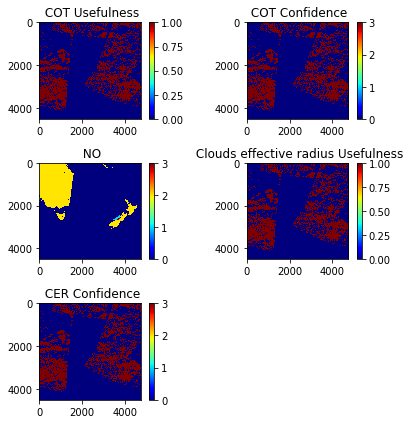

In [35]:
fig = plt.figure(figsize=(6,6))

name_list = [
    "COT Usefulness",
    "COT Confidence",
    "NO",
    "Clouds effective radius Usefulness",
    "CER Confidence"
]

for i in range(5):
    ax = plt.subplot(3,2,i+1)
    plt.imshow(da_array[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title(" %s" % name_list[i])
fig.tight_layout()
plt.show()

In [36]:
## diff between COT usefulness and conf
res = da_array[:,:,0]*3 - da_array[:,:,1]

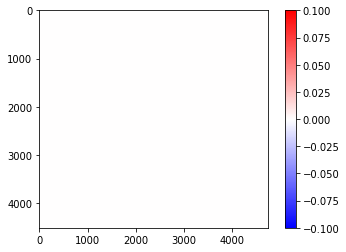

In [40]:
plt.imshow(res, cmap='bwr')
plt.colorbar()

2 Byte

In [41]:
bits2_list = [
    [0,1],
    [1,2],
    [3,3],
    [7,1]
]

In [42]:
da2_array = np.zeros((4513, 4748, 4))

for i in range(4513):
    for j in range(4748):
        for idx, nbit in enumerate(bits2_list):
            ii,jj = nbit
            da2_array[i,j,idx] = bits_stripping(ii,jj, m6_qa[i,j, 1])  

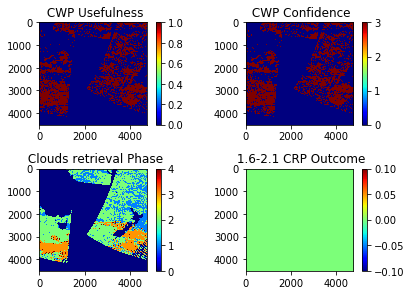

In [47]:
fig = plt.figure(figsize=(6,6))

name_list = [
    "CWP Usefulness",
    "CWP Confidence",
    "Clouds retrieval Phase",
    "1.6-2.1 CRP Outcome"
]

for i in range(4):
    ax = plt.subplot(3,2,i+1)
    plt.imshow(da2_array[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title(" %s" % name_list[i])
fig.tight_layout()
plt.show()

In [61]:
## diff between COT usefulness and conf
res2 = da2_array[:,:,0]*3 - da2_array[:,:,1]

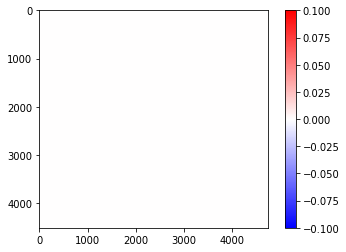

In [62]:
plt.imshow(res, cmap='bwr')
plt.colorbar()

### Check differrene with and without QA flag

Get image

In [51]:
hdf_filelist=[
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Optical_Thickness.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Water_Path.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Phase_Infrared.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Top_Pressure.hdf",
]
hdf_datadir = filedir

In [52]:
cot_hdf = SD(hdf_datadir+'/'+hdf_filelist[0], SDC.READ)
cwp_hdf = SD(hdf_datadir+'/'+hdf_filelist[1], SDC.READ)
cpi_hdf = SD(hdf_datadir+'/'+hdf_filelist[2], SDC.READ)
ctp_hdf = SD(hdf_datadir+'/'+hdf_filelist[3], SDC.READ)

In [53]:
cot_sds = cot_hdf.select("Cloud_Optical_Thickness")
cwp_sds = cwp_hdf.select("Cloud_Water_Path")
cpi_sds = cpi_hdf.select("Cloud_Phase_Infrared")
ctp_sds = ctp_hdf.select("Cloud_Top_Pressure")

In [54]:
cot_array = mod06_proc_sds(cot_sds, variable="Cloud_Optical_Thickness")
cwp_array = mod06_proc_sds(cwp_sds)
cpi_array = mod06_proc_sds(cpi_sds)
ctp_array = mod06_proc_sds(ctp_sds)

/home/tkurihana/clouds/src_analysis/lib_hdfs/analysis_lib.py:361: RuntimeWarning: invalid value encountered in greater
  err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit


In [55]:
nx, ny = cot_array.shape
d_list = [
    cot_array.reshape(nx,ny,1),
    cwp_array.reshape(nx,ny,1),
    cpi_array.reshape(nx,ny,1),
    ctp_array.reshape(nx,ny,1),
]

In [56]:
mod06_img = np.concatenate(d_list, axis=2)

#### load cloud_xy_list 

In [67]:
clouds_xy_list = np.load("./Clouds_XY_List.npy")

In [68]:
clouds_xy_list.shape

(764, 2)

#### make patches

Without QA

In [81]:
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [82]:
mod06_patches_mean = np.nanmean(mod06_patches, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [83]:
prep_phase = copy.deepcopy(mod06_patches[:,:,:,:,2])
_x, _y = mod06_patches.shape[:2]
phase_mode = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase[i,j].ravel(), nan_policy='omit')
        phase_mode[i,j] = phase
cpi_modes = np.zeros((_x,_y)).astype(np.float64)
cpi_modes[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cpi_modes[x,y] = phase_mode[x,y]
    
#back to array
mod06_patches_mean[:,:,2] = cpi_modes

With QA in Cloud optical thickness and Cloud water patch

In [60]:
da_array.shape, da2_array.shape

((4513, 4748, 5), (4513, 4748, 4))

In [86]:
qa_cot_array = copy.copy(cot_array)
qa_cwp_array = copy.copy(cwp_array)

for ix in range(nx):
    for jy in range(ny):
        # cot
        cot_qa_flag = da_array[ix, jy, 0]
        if cot_qa_flag ==0:
            qa_cot_array[ix,jy] = np.nan
            
        # cwp
        cwp_qa_flag = da2_array[ix, jy, 0]
        if cwp_qa_flag == 0:
            qa_cwp_array[ix,jy] = np.nan

In [87]:
_d_list = [
    qa_cot_array.reshape(nx,ny,1),
    qa_cwp_array.reshape(nx,ny,1),
    cpi_array.reshape(nx,ny,1),
    ctp_array.reshape(nx,ny,1),
]

qa_mod06_img = np.concatenate(_d_list, axis=2)

In [88]:
qa_mod06_patches = _gen_patches(qa_mod06_img, normalization=False, flag_nan=True)

In [89]:
qa_mod06_patches_mean = np.nanmean(qa_mod06_patches, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [90]:
prep_phase = copy.deepcopy(qa_mod06_patches[:,:,:,:,2])
_x, _y = qa_mod06_patches.shape[:2]
phase_mode = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase[i,j].ravel(), nan_policy='omit')
        phase_mode[i,j] = phase
cpi_modes = np.zeros((_x,_y)).astype(np.float64)
cpi_modes[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cpi_modes[x,y] = phase_mode[x,y]
    
#back to array
qa_mod06_patches_mean[:,:,2] = cpi_modes

#### Compare by mapping

eliminate less clouds patches

In [111]:
nqa_array = np.zeros(mod06_patches_mean.shape).astype(np.float64)
qa_array = np.zeros(qa_mod06_patches_mean.shape).astype(np.float64)
nqa_array[:,:,:] = np.nan
qa_array[:,:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    nqa_array[x,y] = mod06_patches_mean[x,y] 
    qa_array[x,y] = qa_mod06_patches_mean[x,y]

1. Without

In [103]:
name_list = [
    "Optical Thickness",
    "Water Path",
    "Phase",
    "Top Pressure"
]

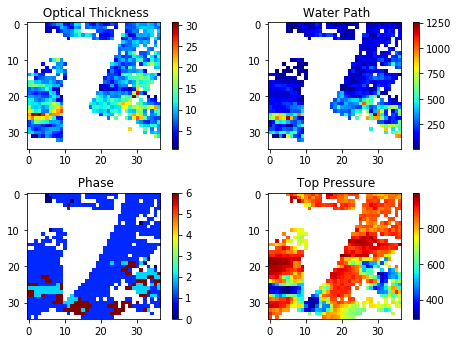

In [112]:
fig = plt.figure(figsize=(7,7))
for i in range(4):
    ax = plt.subplot(3,2,i+1)
    plt.imshow(nqa_array[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title(" %s" % name_list[i])
fig.tight_layout()
plt.show()

2. With

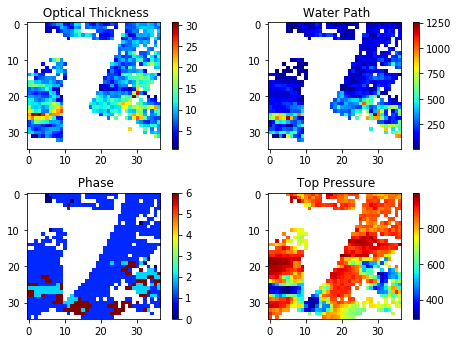

In [113]:
fig = plt.figure(figsize=(7,7))
for i in range(4):
    ax = plt.subplot(3,2,i+1)
    plt.imshow(qa_array[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title(" %s" % name_list[i])
fig.tight_layout()
plt.show()

In [114]:
len(np.where(~np.isnan(nqa_array))[0]) ,len(np.where(~np.isnan(qa_array))[0])

(2760, 2760)

In [117]:
ncot = 0
ncwp = 0
nx, ny = cot_array.shape
for ix in range(nx):
    for jy in range(ny):
        # cot
        cot_qa_flag = da_array[ix, jy, 0]
        if cot_qa_flag ==0:
            qa_cot_array[ix,jy] = np.nan
            ncot += 1
            
        # cwp
        cwp_qa_flag = da2_array[ix, jy, 0]
        if cwp_qa_flag == 0:
            qa_cwp_array[ix,jy] = np.nan
            ncwp += 1

In [118]:
ncot, ncwp

(15528550, 15528550)

In [123]:
ncot = 0
ncwp = 0
nx, ny = cot_array.shape
_cot_array = np.zeros(cot_array.shape).astype(np.float64)
_cwp_array = np.zeros(cwp_array.shape).astype(np.float64)
for ix in range(nx):
    for jy in range(ny):
        # cot
        cot_qa_flag = da_array[ix, jy, 0]
        if cot_qa_flag ==0:
            _cot_array[ix,jy] = np.nan
            ncot += 1
            
        # cwp
        cwp_qa_flag = da2_array[ix, jy, 0]
        if cwp_qa_flag == 0:
            _cwp_array[ix,jy] = np.nan
            ncwp += 1

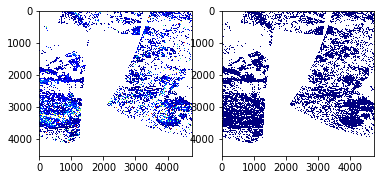

In [124]:
fig = plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(cot_array, 'jet')
ax = plt.subplot(1,2,2)
plt.imshow(_cot_array, 'jet')
plt.show()

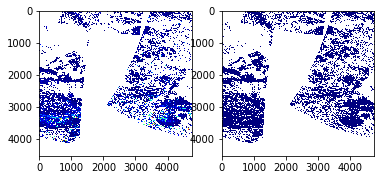

In [125]:
fig = plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(cwp_array, 'jet')
ax = plt.subplot(1,2,2)
plt.imshow(_cwp_array, 'jet')
plt.show()

Look histogram

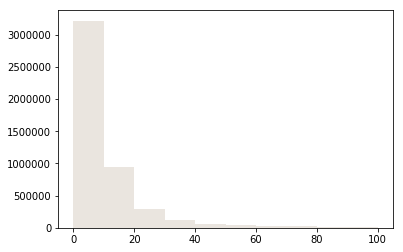

In [130]:
plt.figure()
plt.hist(cot_array.ravel(), alpha=0.1)
plt.hist(qa_cot_array.ravel(), alpha=0.1)
plt.show()

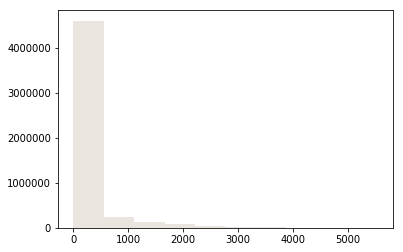

In [131]:
plt.figure()
plt.hist(cwp_array.ravel(), alpha=0.1)
plt.hist(qa_cwp_array.ravel(), alpha=0.1)
plt.show()

### Result
No harmmful effect on test image